In [9]:
# !pip install xgboost

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB 217.9 kB/s eta 0:09:34
   ---------------------------------------- 0.0/124.9 MB 217.9 kB/s eta 0:09:34
   ---------------------------------------- 0.0/124.9 MB 163.8 kB/s eta 0:12:43
   ---------------------------------------- 0.1/124.9 MB 217.9 kB/s eta 0:09:34
   ---------------------------------------- 0.1/124.9 MB 233.8 kB/s eta 0:08:55
   ---------------------------------------- 0.1/124.9 MB 291.5 kB/s eta 0:07:09
   ---------------------------------------- 0.2/124.9 MB 468.3 kB/s eta 0:04:27
   ---------------------------------------- 0.2/124.9 MB 546.1 kB/s eta 0:03:49
   ---------------------------------------- 0.3/124.9 MB 582.4 kB/s eta 0:03:35
   ---------------------------------------- 0.3/124.9 MB 723.4 kB

In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

In [4]:
df = pd.read_csv('district_aqi_data.csv')

In [5]:
df

,date,Attock,Bahawalnagar,Bahawalpur,Bhakkar,Chakwal,Chiniot,Dera Ghazi Khan,Faisalabad,Gujranwala,...,Pakpattan,Rahim Yar Khan,Rajanpur,Rawalpindi,Sahiwal,Sargodha,Sheikhupura,Sialkot,Toba Tek Singh,Vehari
0,2022-08-31 19:00:00,170.958438,43.541111,36.650405,68.268409,120.57800,71.510625,71.676667,61.792500,173.631250,...,53.619167,40.999688,43.95850,137.692222,57.880357,114.035455,172.699687,115.45450,61.320000,48.4570
1,2022-08-31 20:00:00,171.064375,43.787778,37.751824,69.024545,115.84450,74.806875,75.946250,63.438214,172.566250,...,52.973333,42.046563,44.38525,135.024167,57.423214,111.987727,167.071875,116.67950,61.709167,48.2950
2,2022-08-31 21:00:00,169.573750,43.814444,38.838851,69.665227,108.81275,78.753750,82.185972,65.361071,171.019375,...,52.251667,43.324219,44.86175,131.898611,56.860000,108.308182,159.777500,119.84925,61.736667,48.1695
3,2022-08-31 22:00:00,161.330000,45.398056,41.151486,67.287500,97.74375,79.370000,86.851111,64.233571,165.816875,...,51.168333,45.090625,46.34000,125.111667,55.196429,101.215909,146.395312,121.06400,60.032500,49.2935
4,2022-08-31 23:00:00,145.478437,48.176667,43.653311,63.889773,90.81900,76.657500,83.061528,61.891786,159.326250,...,51.315833,45.976562,48.21600,109.569444,54.755000,96.415682,134.316875,120.61325,57.900000,52.2830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18187,2024-10-28 19:00:00,90.378750,96.087778,108.442895,112.631818,105.50250,120.418750,110.416389,109.756429,120.705000,...,103.330000,135.139062,108.25300,138.592778,131.525714,115.509091,116.790000,128.87650,125.876667,240.0240
18188,2024-10-28 20:00:00,79.730625,88.411111,107.339342,108.644091,100.24900,116.578750,101.303611,106.125000,114.260000,...,96.561667,132.193125,99.45550,122.821111,121.337857,112.010455,115.336875,118.32400,117.413333,229.7790
18189,2024-10-28 21:00:00,71.650625,82.096111,105.969868,104.949091,94.45150,113.638750,93.584167,103.637143,108.852500,...,91.866667,130.639375,92.36000,107.729444,112.990000,108.800455,114.620000,109.87850,110.205000,219.8300
18190,2024-10-28 22:00:00,67.839375,78.056111,104.709737,102.277273,88.46450,111.258750,88.250833,102.150714,104.623750,...,89.753333,132.437813,88.54050,94.422222,106.922143,105.854545,114.362500,104.22650,104.348333,210.9780


In [10]:
def prepare_and_train_xgboost(df, column_name):
    # Ensure date is a datetime object
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
    
    # Select the specified column and create a DataFrame
    data = df[[column_name]].copy()
    
    # Extract date-time features
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['day_of_week'] = data.index.dayofweek
    data['hour'] = data.index.hour

    # Create lagged features and rolling means
    for lag in [6, 12, 24, 48, 72]:  # Lag intervals in hours (6 hours, 12 hours, etc.)
        data[f'lag_{lag}'] = data[column_name].shift(lag)
        data[f'rolling_mean_{lag}'] = data[column_name].shift(1).rolling(window=lag).mean()
    
    # Fill missing values with previous values
    data.fillna(method='ffill', inplace=True)
    
    # Define target and features
    X = data.drop(columns=[column_name])
    y = data[column_name]
    
    # Split into train and test sets (last 30 days for testing)
    train_size = len(data) - 24 * 30  # Assuming 24 hourly entries per day
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
    
    # Train an XGBoost model with default parameters
    model = XGBRegressor()
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate and print RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    
    return model, X_test, y_test, y_pred

In [12]:
# Example usage
model, X_test, y_test, y_pred = prepare_and_train_xgboost(df, 'Attock')


C:\Users\timmy_3aupohg\AppData\Local\Temp\ipykernel_24356\3177590558.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


Root Mean Squared Error (RMSE): 14.3749268204454


In [11]:
import matplotlib.pyplot as plt
import xgboost as xgb

def plot_predictions(y_test, y_pred):
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test, label="Actual", color="blue")
    plt.plot(y_test.index, y_pred, label="Predicted", color="red")
    plt.title("Actual vs Predicted Values")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.legend()
    plt.show()

def plot_feature_importance(model, feature_names):
    # Convert to DMatrix for XGBoost feature importance plotting
    xgb.plot_importance(model, importance_type='weight', title="Feature Importance", xlabel="F Score", ylabel="Features")
    plt.show()

# Plot predictions
# plot_predictions(y_test, y_pred)

# # Plot feature importance
# plot_feature_importance(model, X_test.columns)


In [12]:
def forecast_future(model, df, column_name, forecast_steps=24*60):
    """
    Forecasts future values for a specified number of steps using an already trained model.
    
    Parameters:
    - model: Trained XGBoost model
    - df: Original DataFrame containing the data
    - column_name: Name of the column to forecast
    - forecast_steps: Number of future steps to forecast (e.g., 24 for 24 hours)
    
    Returns:
    - forecasts: List of forecasted values
    """
    # Ensure the 'date' column is datetime and set as index
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
    
    # Copy the last part of the data to start forecasting
    data = df[[column_name]].copy()
    
    # Initialize a list to store the forecasted values
    forecasts = []
    
    for _ in range(forecast_steps):
        # Extract date-time features
        data['month'] = data.index.month
        data['day'] = data.index.day
        data['day_of_week'] = data.index.dayofweek
        data['hour'] = data.index.hour

        # Create lagged features and rolling means
        for lag in [6, 12, 24, 48, 72]:  # Lag intervals in hours
            data[f'lag_{lag}'] = data[column_name].shift(lag)
            data[f'rolling_mean_{lag}'] = data[column_name].shift(1).rolling(window=lag).mean()
        
        # Fill missing values
        data.fillna(method='ffill', inplace=True)
        
        # Use the latest available row for prediction
        X_last = data.iloc[[-1]].drop(columns=[column_name])

        # Forecast the next value
        forecast = model.predict(X_last)[0]
        forecasts.append(forecast)
        
        # Create a new row with the forecasted value and concatenate
        new_row = pd.DataFrame({column_name: forecast}, index=[data.index[-1] + pd.Timedelta(hours=1)])
        data = pd.concat([data, new_row])
    
    # Return the forecasted values as a DataFrame with timestamps
    forecast_index = pd.date_range(start=data.index[-forecast_steps], periods=forecast_steps, freq='H')
    forecast_df = pd.DataFrame({f'{column_name}_forecast': forecasts}, index=forecast_index)
    
    return forecast_df

# Example usage
# forecast_df = forecast_future(model, df, 'Attock', forecast_steps=24)
# print(forecast_df)


In [21]:
# Example usage
forecast_df = forecast_future(model, df, 'Attock')
forecast_df

C:\Users\timmy_3aupohg\AppData\Local\Temp\ipykernel_24356\3069166784.py:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
C:\Users\timmy_3aupohg\AppData\Local\Temp\ipykernel_24356\3069166784.py:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
C:\Users\timmy_3aupohg\AppData\Local\Temp\ipykernel_24356\3069166784.py:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
C:\Users\timmy_3aupohg\AppData\Local\Temp\ipykernel_24356\3069166784.py:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method

,Attock_forecast
2024-10-29 00:00:00,77.816780
2024-10-29 01:00:00,65.396828
2024-10-29 02:00:00,64.853577
2024-10-29 03:00:00,61.631142
2024-10-29 04:00:00,71.566414
...,...
2024-12-27 19:00:00,168.276108
2024-12-27 20:00:00,169.321701
2024-12-27 21:00:00,173.306854
2024-12-27 22:00:00,182.681503


In [22]:
forecast_df.head(20)

,Attock_forecast
2024-10-29 00:00:00,77.816780
2024-10-29 01:00:00,65.396828
2024-10-29 02:00:00,64.853577
2024-10-29 03:00:00,61.631142
2024-10-29 04:00:00,71.566414
2024-10-29 05:00:00,71.396660
2024-10-29 06:00:00,70.781990
2024-10-29 07:00:00,65.680473
2024-10-29 08:00:00,67.348236
2024-10-29 09:00:00,67.149178


<Axes: title={'center': 'Forecasted Values'}>

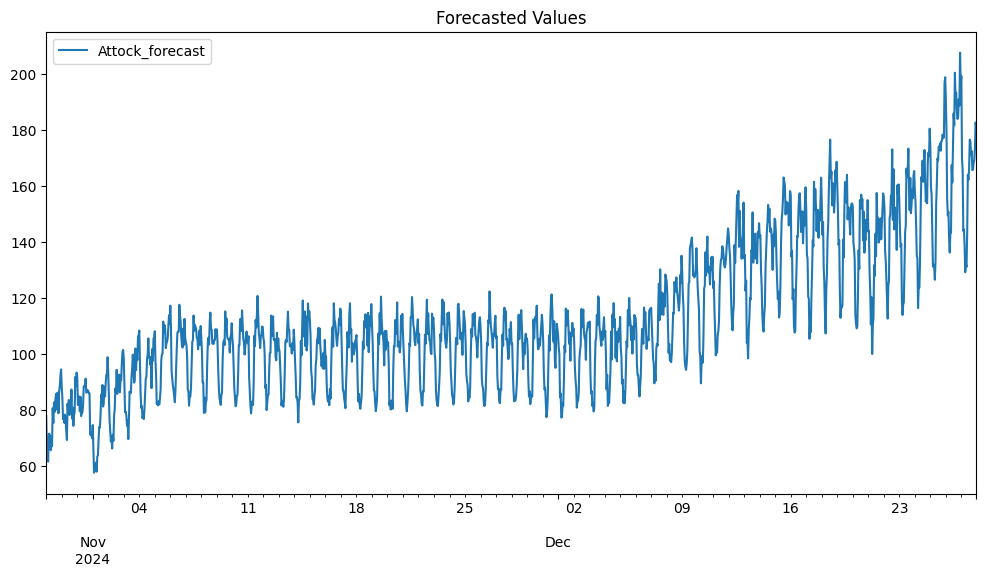

In [23]:
forecast_df.plot(figsize=(12, 6), title="Forecasted Values")

In [30]:
df.columns

Index(['date', 'Attock', 'Bahawalnagar', 'Bahawalpur', 'Bhakkar', 'Chakwal',
       'Chiniot', 'Dera Ghazi Khan', 'Faisalabad', 'Gujranwala', 'Gujrat',
       'Hafizabad', 'Jhang', 'Jhelum', 'Kasur', 'Khanewal', 'Khushab',
       'Lahore', 'Layyah', 'Lodhran', 'Mandi Bahuddin', 'Mianwali', 'Multan',
       'Muzaffargarh', 'Nankana Sahib', 'Narowal', 'Okara', 'Pakpattan',
       'Rahim Yar Khan', 'Rajanpur', 'Rawalpindi', 'Sahiwal', 'Sargodha',
       'Sheikhupura', 'Sialkot', 'Toba Tek Singh', 'Vehari'],
      dtype='object')

In [13]:
def all_district_forecasts(df, forecast_steps=90):
    # Initialize an empty DataFrame to store forecasts
    all_forecasts = pd.DataFrame()
    
    # List of columns to skip (date is assumed to be the first column)
    district_columns = df.columns[1:]
    
    # Loop through each district
    for district in district_columns:
        print(f"\nProcessing district: {district}")
        
        # Preprocess and train model for the current district
        model, X_test, y_test, y_pred = prepare_and_train_xgboost(df, district)
        
        # Plot actual vs predicted for the test set
        plot_predictions(y_test, y_pred)
        
        # Forecast for the next 3 months (approx. 90 days, or 90 * 24 hours)
        forecast_df = forecast_future(model, df, district, forecast_steps=forecast_steps*24)
        
        # Plot the forecasted data
        plt.figure(figsize=(10, 5))
        plt.plot(forecast_df.index, forecast_df[f'{district}_forecast'], label="Forecast", color="orange")
        plt.title(f"{district} - 3-Month Forecast")
        plt.xlabel("Date")
        plt.ylabel("Forecasted Values")
        plt.legend()
        plt.show()
        
        # Append the forecast to the all_forecasts DataFrame
        forecast_df = forecast_df.rename(columns={f'{district}_forecast': district})
        if all_forecasts.empty:
            all_forecasts = forecast_df
        else:
            all_forecasts = pd.concat([all_forecasts, forecast_df], axis=1)
    
    # Reset index to include the date column and save as CSV
    all_forecasts.reset_index(inplace=True)
    all_forecasts.rename(columns={'index': 'date'}, inplace=True)
    all_forecasts.to_csv('all_districts_forecasts.csv', index=False)
    
    print("\nForecasting completed for all districts. Results saved as 'all_districts_forecasts.csv'.")
    return all_forecasts


In [14]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [15]:
from concurrent.futures import ThreadPoolExecutor, as_completed

# Make sure to define prepare_and_train_xgboost, plot_predictions, and forecast_future functions here

def process_district(df, district, forecast_steps=90):
    """Process each district: train model, forecast, and plot."""
    print(f"\nProcessing district: {district}")
    
    # Train model for the current district
    model, X_test, y_test, y_pred = prepare_and_train_xgboost(df, district)
    
    # Plot actual vs predicted for the test set
    plot_predictions(y_test, y_pred)
    
    # Forecast for the next 3 months (approx. 90 days, or 90 * 24 hours)
    forecast_df = forecast_future(model, df, district, forecast_steps=forecast_steps*24)
    
    # Plot the forecasted data
    plt.figure(figsize=(10, 5))
    plt.plot(forecast_df.index, forecast_df[f'{district}_forecast'], label="Forecast", color="orange")
    plt.title(f"{district} - 3-Month Forecast")
    plt.xlabel("Date")
    plt.ylabel("Forecasted Values")
    plt.legend()
    plt.show()
    
    # Rename forecast column for easy merging later
    forecast_df = forecast_df.rename(columns={f'{district}_forecast': district})
    return forecast_df



def all_district_forecasts_concurrent(df, forecast_steps=90):
    # Initialize an empty DataFrame to store all forecasts
    all_forecasts = pd.DataFrame()
    
    # List of columns to skip (date is assumed to be the first column)
    district_columns = df.columns[1:]
    
    # Use ThreadPoolExecutor for parallel processing with threads
    with ThreadPoolExecutor() as executor:
        futures = {executor.submit(process_district, df, district, forecast_steps): district for district in district_columns}
        
        for future in as_completed(futures):
            district = futures[future]
            try:
                forecast_df = future.result()
                if all_forecasts.empty:
                    all_forecasts = forecast_df
                else:
                    all_forecasts = pd.concat([all_forecasts, forecast_df], axis=1)
            except Exception as e:
                print(f"Error processing {district}: {e}")
    
    all_forecasts.reset_index(inplace=True)
    all_forecasts.rename(columns={'index': 'date'}, inplace=True)
    all_forecasts.to_csv('all_districts_forecasts.csv', index=False)
    
    print("\nForecasting completed for all districts. Results saved as 'all_districts_forecasts.csv'.")
    return all_forecasts

    return all_forecasts

In [ ]:
# Example usage
all_forecasts = all_district_forecasts_concurrent(df, forecast_steps=90)

In [33]:
forecasts = pd.read_csv('all_districts_forecasts.csv')

In [34]:
forecasts.head()

,date,Attock,Bahawalnagar,Bahawalpur,Bhakkar,Chakwal,Chiniot,Dera Ghazi Khan,Faisalabad,Gujranwala,...,Pakpattan,Rahim Yar Khan,Rajanpur,Rawalpindi,Sahiwal,Sargodha,Sheikhupura,Sialkot,Toba Tek Singh,Vehari
0,2024-10-29 00:00:00,77.816780,77.649765,105.95218,110.108410,99.42575,120.580690,92.941230,104.056435,104.403885,...,88.81882,139.050420,100.607320,113.562225,104.700880,119.14796,128.42255,116.57926,108.787190,195.05843
1,2024-10-29 01:00:00,65.396830,80.933990,98.35224,105.109710,83.84662,106.703990,68.169730,97.397156,102.843310,...,92.74704,116.147530,91.028510,87.646710,98.519165,106.49239,129.08574,94.17206,102.246030,157.09648
2,2024-10-29 02:00:00,64.853580,73.466720,90.83415,99.656006,76.10435,101.279625,68.156624,93.916695,87.389680,...,97.56995,119.646720,80.979710,89.166420,97.612434,99.29945,122.44303,95.97982,85.987980,164.14046
3,2024-10-29 03:00:00,61.631140,62.982330,91.89674,95.834540,73.32068,126.227010,64.741090,101.597810,88.916560,...,89.13988,113.684525,75.326320,81.872200,98.551340,93.71585,124.54166,92.31147,100.507645,176.85796
4,2024-10-29 04:00:00,71.566414,75.059364,83.15211,100.855760,78.88755,120.420660,68.735830,108.854400,92.127500,...,101.11582,111.811700,78.749794,74.387990,93.900700,97.94021,132.98828,97.33899,103.504974,117.23405


In [35]:
# Corrected melting of the data with the actual column name
forecasts_melted = pd.melt(forecasts, id_vars='date', var_name='District', value_name='Final_aqi')

In [36]:
forecasts_melted.head()

,date,District,Final_aqi
0,2024-10-29 00:00:00,Attock,77.816780
1,2024-10-29 01:00:00,Attock,65.396830
2,2024-10-29 02:00:00,Attock,64.853580
3,2024-10-29 03:00:00,Attock,61.631140
4,2024-10-29 04:00:00,Attock,71.566414


In [37]:
# renaming date as Date
forecasts_melted.rename(columns={'date': 'Date'}, inplace=True)

In [38]:
# # exporting the data to csv
forecasts_melted.to_csv('new_xgb_hr_forecasts.csv', index=False)

In [39]:
# Convert the 'Date' column to datetime format
forecasts_melted['Date'] = pd.to_datetime(forecasts_melted['Date'])

# Group by 'District' and resample the 'Date' to daily frequency, then calculate the mean of 'Final_aqi'
forecasts_daily = forecasts_melted.groupby('District').resample('D', on='Date')['Final_aqi'].max().reset_index()

# Displaying the resulting DataFrame
forecasts_daily.head()


,District,Date,Final_aqi
0,Attock,2024-10-29,94.51043
1,Attock,2024-10-30,93.39410
2,Attock,2024-10-31,91.84215
3,Attock,2024-11-01,98.88677
4,Attock,2024-11-02,101.48104


In [40]:
forecasts_daily

,District,Date,Final_aqi
0,Attock,2024-10-29,94.51043
1,Attock,2024-10-30,93.39410
2,Attock,2024-10-31,91.84215
3,Attock,2024-11-01,98.88677
4,Attock,2024-11-02,101.48104
...,...,...,...
3235,Vehari,2025-01-22,138.49811
3236,Vehari,2025-01-23,133.78682
3237,Vehari,2025-01-24,124.02453
3238,Vehari,2025-01-25,138.82391


In [41]:
36*90

3240

In [42]:
# # exporting the data to csv
forecasts_daily.to_csv('new_xgb_daily_forecasts.csv', index=False)